# Decision tree classifier

In [4]:
import pandas as pd
import numpy as np
import shap

from src.processing import import_data
from src.model_selection import test_model
from src.debias_data import debias_data

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from graphviz import Source

In [5]:
def remove_protected(protected_cols):
    def call(X_train, X_test):
        return X_train.drop(columns=protected_cols), X_test.drop(columns=protected_cols)
    return call

In [6]:
# Get data
data_init, data_full, data, data_protected, data_y = import_data()

# Define features
y_cols = ['ViolentCrimesPerPop', 'HighCrime']
protected_cols = ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']
index_cols = ['IsBlack']
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

# Initialize X (without the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y['HighCrime']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create dataset without protected columns
scaler_nonprot = remove_protected(protected_cols)
X_train_nonprot, X_test_wo_prot = scaler_nonprot(X_train, X_test)

# Create debiased dataset
l_value = 0.2
scaler_debias = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
X_train_debiased, X_test_debiased = scaler_debias(X_train, X_test)
X_train_debiased = pd.DataFrame(X_train_debiased, columns=nonprotected_cols)

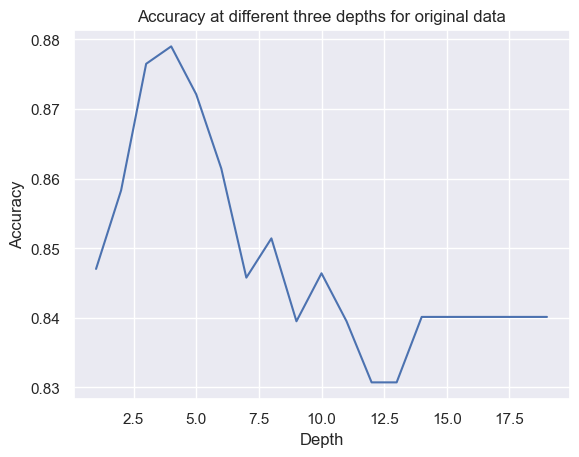

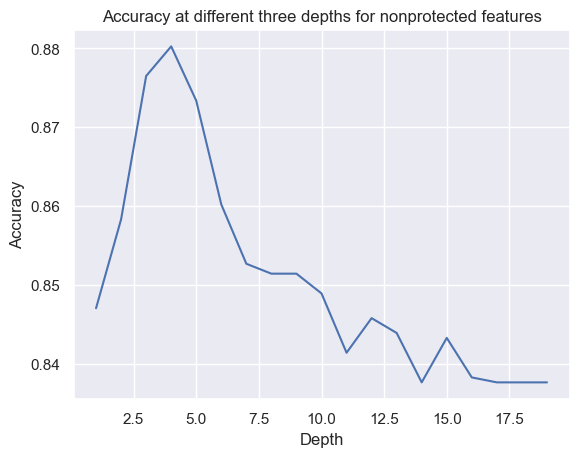

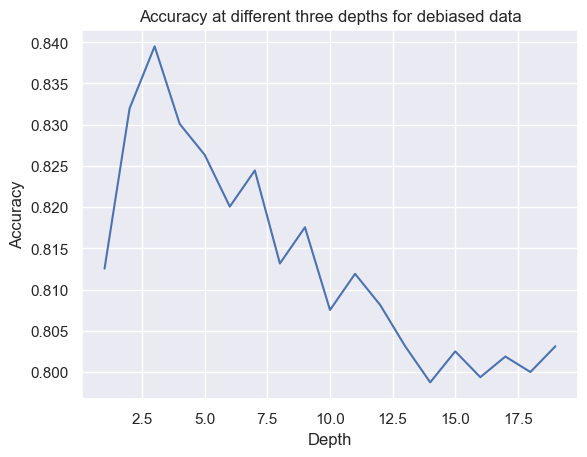

In [7]:
# Define model
model = DecisionTreeClassifier

# Find optimal depth of threes
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
descriptions = ['original data', 'nonprotected features', 'debiased data']
for scaler, desc in zip([None, scaler_nonprot, scaler_debias], descriptions):
    depths = [i for i in range(1, 20)]
    scores = []
    for i in depths:
        model_params = {'random_state':1, 'max_depth':i}
        preds = test_model(model, X_train, y_train, kfold, scaler=scaler, model_params=model_params)
        acc = accuracy_score(preds, y_train)
        scores.append(acc)

    # Plot accuracy at each depth
    plt.plot(depths, scores)
    plt.title(f'Accuracy at different three depths for {desc}')
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.show()

In [43]:
# Fit models
X_splits = [X_train, X_train_nonprot, X_train_debiased]
max_depth = 3
model_instances = []
for X_split in X_splits:
    model_instance = model(max_depth=max_depth, random_state=1)
    model_instance.fit(X=X_split, y=y_train)
    model_instances.append(model_instance)

# Get importance of each feature
top_k = 7
columns = [protected_cols+nonprotected_cols, nonprotected_cols, nonprotected_cols]
indices = []
print('Feature importances for model trained on..')
for model_instance, cols, description in zip(model_instances, columns, descriptions):
    importances = model_instance.feature_importances_
    index = np.argsort(-importances)
    indices.append(index)
    print(f'\t{description}:')
    for feature, importance in zip(np.array(cols)[index][:top_k], importances[index][:top_k]):
        print(f'\t\t{feature}: {importance:.5f}')

Feature importances for model trained on..
	original data:
		PctIlleg: 0.74308
		NumIlleg: 0.09717
		PctKids2Par: 0.06560
		HousVacant: 0.05603
		PctPersDenseHous: 0.02324
		PctYoungKids2Par: 0.01487
		PctImmigRec8: 0.00000
	nonprotected features:
		PctIlleg: 0.74308
		NumIlleg: 0.09717
		PctKids2Par: 0.06560
		HousVacant: 0.05603
		PctPersDenseHous: 0.02324
		PctYoungKids2Par: 0.01487
		population: 0.00000
	debiased data:
		PctIlleg: 0.43246
		LemasPctOfficDrugUn: 0.42382
		NumIlleg: 0.08875
		MedNumBR: 0.05496
		PctHousOccup: 0.00000
		HousVacant: 0.00000
		PctHousLess3BR: 0.00000


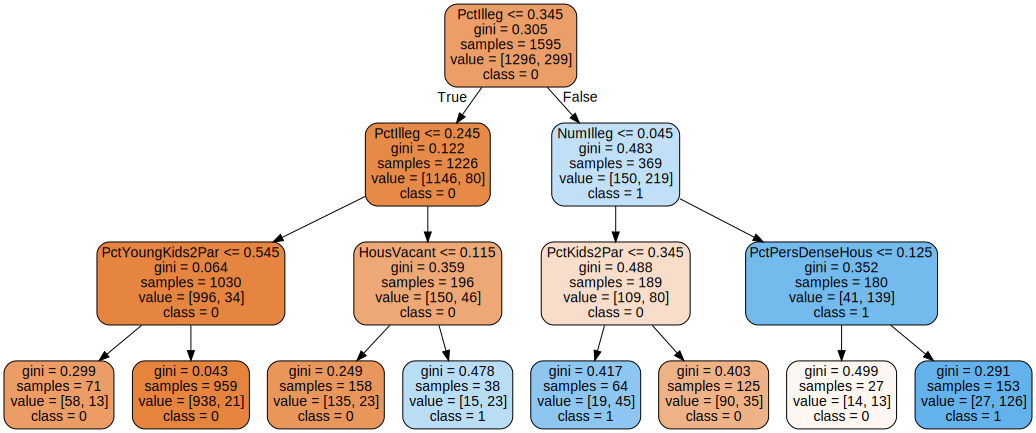

In [35]:
# Visualize decision tree for original data
graph = Source(tree.export_graphviz(model_instances[0], feature_names=X_train.columns, class_names=model_instances[0].classes_.astype(str), filled=True, rounded=True)  
)
graph.format = 'png'
graph.render('tree', view=True)
graph

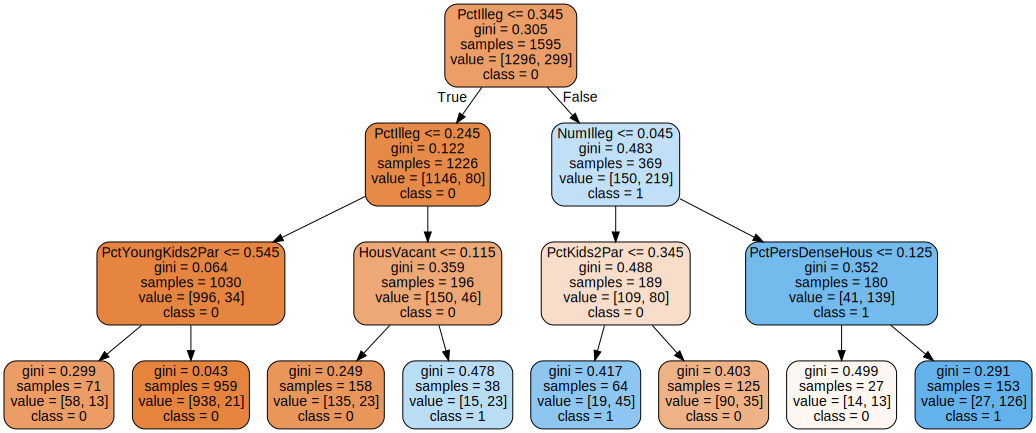

In [36]:
# Visualize decision tree for nonprotected features
graph = Source(tree.export_graphviz(model_instances[1], feature_names=X_train_nonprot.columns, class_names=model_instances[1].classes_.astype(str), filled=True, rounded=True)  
)
graph.format = 'png'
graph.render('tree', view=True)
graph

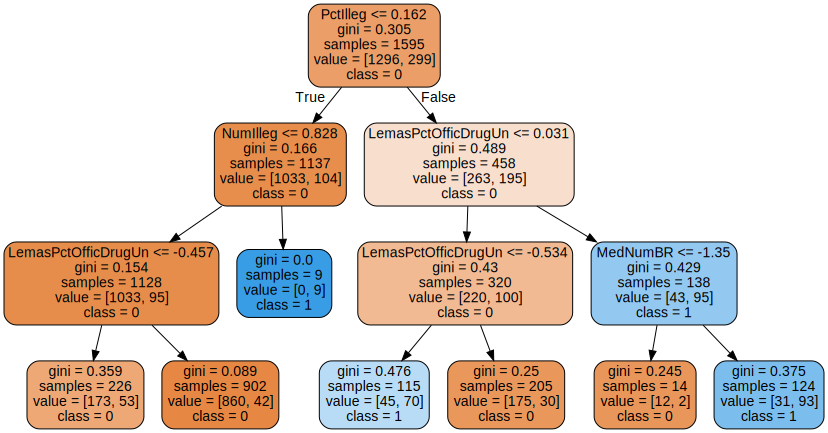

In [37]:
# Visualize decision tree for debiased data
graph = Source(tree.export_graphviz(model_instances[2], feature_names=X_train_debiased.columns, class_names=model_instances[2].classes_.astype(str), filled=True, rounded=True)  
)
graph.format = 'png'
graph.render('tree', view=True)
graph

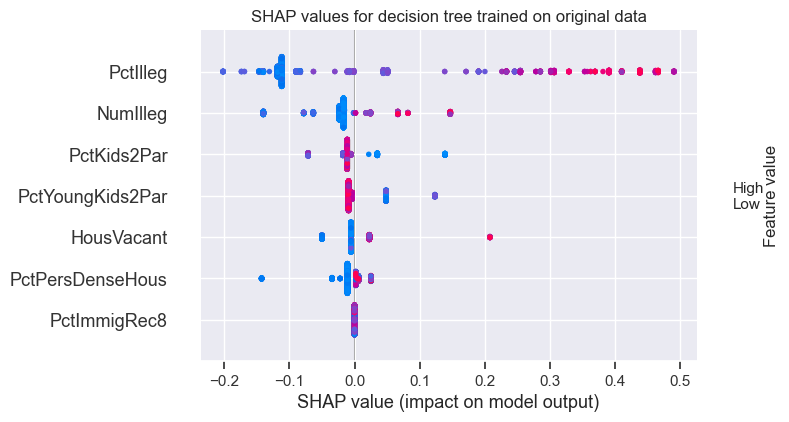

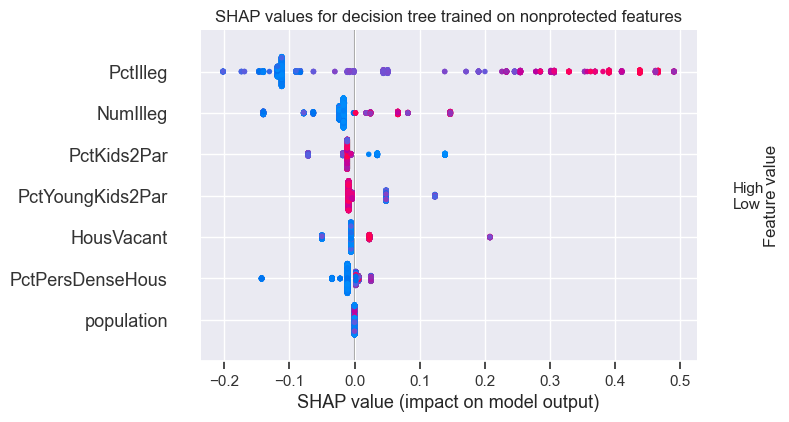

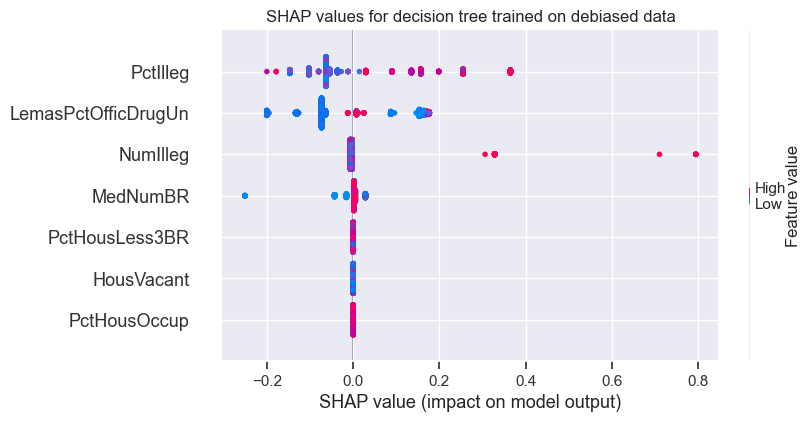

In [51]:
# Plot Shap values of decision tree model
for model_instance, X_split, index, description in zip(model_instances, X_splits, indices, descriptions):
    explainer = shap.TreeExplainer(model=model_instance)
    shap_values = explainer.shap_values(X_split)
    plot = shap.summary_plot(shap_values[1][:,index[:top_k]], X_split.iloc[:,index[:top_k]], show=False)
    plt.title(f'SHAP values for decision tree trained on {description}')
    # plt.tight_layout()
    # plt.savefig('shap_descision.png')
    # plt.gcf()
    plt.show()

# Logistic regression model

In [52]:
from sklearn.linear_model import LogisticRegression